## Loading up packages

In [2]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [3]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, GenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
import plastid
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

In [4]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/"
position_count_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/dmel/"
te_table_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/dmel/'
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/dmel/"
save_path2 = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/initiation_rates/dmel/"
save_path3 = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/termination_rates/dmel/"
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/dmel/'
gtf_name = "Drosophila_melanogaster.BDGP6.32.103.gtf"
mutation = 'Fmr1'
samp_num = '3'

## Loading up the data files 

In [5]:
init_mutant = np.loadtxt(save_path2 + mutation + '_' + samp_num + '_adjusted_initiation_rates', delimiter = ",")

In [6]:
term_mutant = np.loadtxt(save_path3 + mutation + '_' + samp_num + '_adjusted_termination_rates', delimiter = ",")

In [7]:
def load_elongation_rates_v2(csv_name, csv_path):
    data = []
    gene_names = []
    tr_ids = []
    with open(csv_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = float(j)
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        gene_names.append(data[ii][1])
        tr_ids.append(data[ii][0])
        data[ii] = np.array(data[ii][2:]) # I think that this is my target, I just need it to also capture
    
    return data, gene_names, tr_ids

In [8]:
# Load in the elongation rates data.
elon_mutant, gene_names, tr_ids = load_elongation_rates_v2(mutation + '_' + samp_num + '_adjusted_elongation_rates', elon_path)
#elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

In [9]:
# Load in the count positions data.
counts_mutant = kat.load_count_positions(mutation+"_"+samp_num+"_counts.csv",position_count_path)
counts_control = kat.load_count_positions("control_"+ samp_num +"_counts.csv",position_count_path)

## Define functions

In [10]:
def get_density(lamb, a, B, I = 10, intermediates = False):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
        density = "LD"
    elif a > crit_a and B < crit_B:
        p = high_density(lamb_c, B, I)
        density = "HD"
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p = low_density(lamb_c, a, I)
            density = "LD"
        elif sign < 0:
            p = high_density(lamb_c, B, I)
            density = "HD"
    elif a > crit_a and B > crit_B:
        p = maximum_current(lamb_c, a, B, I)
        density = "MC"
    if intermediates == False:
        return p, density
    elif intermediates == True:
        return p, a, B, crit_a, crit_B, min(lamb_c), lamb_c[0]
    
def get_critical_values(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    return(crit_a, crit_B)

## Clean data

In [68]:
elon_mutant[30703]

array([365.935774  , 365.935774  , 278.28031191, 265.53039809,
       265.53039809, 253.88916335, 253.88916335, 181.85873   ,
       123.10970413, 113.27964589, 104.87935339,  97.61802678,
       106.86276161, 101.12130574,  97.61802678, 101.12130574,
       111.05842075,  88.40163085,  71.40848757,  69.61242073,
        70.49936862,  74.27750893,  58.5024523 ,  36.78022654,
        33.90710637,  30.86022703,  26.22105135,  22.72124913,
        25.94853217,  23.37300082,  21.60852818,  21.60852818,
        23.59786668,  31.42783904,  33.04111523,  35.28879044,
        37.04039433,  44.89690988,  43.79214201,  49.9024153 ,
        56.6803606 ,  47.69309575,  45.27704165,  43.08394934,
        45.27704165,  46.45512548,  50.84186038,  65.48348913,
        63.96179891,  72.34061953,  78.46964594, 102.96677744,
       115.58971586, 148.81882965, 148.81882965, 134.76853253,
       156.98315759, 148.81882965, 187.79674965, 200.90132314,
        61.11473842,  42.73795965,  41.40524295,  40.45

In [128]:
x = [np.array([-2,-5,-6]), np.array([4,6,7]), np.array([4,8,8, -0.00003])]

In [141]:
x = 0
for el_m in Fmr1_elon_table.elon_rate:
    x = x+1
    if np.any(el_m<0) == False:
        print(x)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [142]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
clean_elons = []
clean_inits = []
clean_terms = []
clean_gene_names = []
clean_tr_ids = []
for tr_m, tr_c, el_m, in_m, term_m, gi, tr_id in zip(counts_mutant, counts_control, elon_mutant, init_mutant, term_mutant, gene_names, tr_ids):
    if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15 and np.any(el_m<0) == False:
        clean_elons.append(el_m)
        clean_inits.append(in_m)
        clean_terms.append(term_m)
        clean_gene_names.append(gi)
        clean_tr_ids.append(tr_id)

In [143]:
len(clean_elons)

7852

In [144]:
crit_as = []
crit_Bs = []
for ce, ci, ct in zip(clean_elons, clean_inits, clean_terms):
    crit_a, crit_B = get_critical_values(ce, ci, ct)
    crit_as.append(crit_a)
    crit_Bs.append(crit_B)

In [145]:
ratio_a = (np.array(clean_inits)/np.array(crit_as))
ratio_B = (np.array(clean_terms))/np.array(crit_Bs)

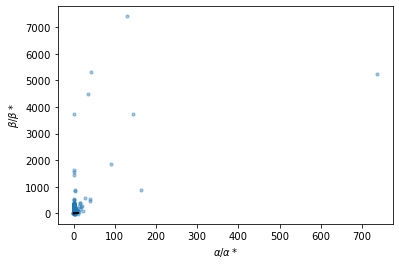

In [165]:
plt.scatter((np.array(clean_inits)/np.array(crit_as)), ((np.array(clean_terms))/np.array(crit_Bs)), s = 10, alpha = 0.4)
#plt.ylim([-1,9])
#plt.xlim([-1,9])
plt.xlabel(r'$\alpha / \alpha * $')
plt.ylabel(r'$\beta / \beta * $')
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

## Next Step, look at Mutant

Also, calculate the median or mean change in elongation rate necessary to 

In [15]:
x = 0
for i in ratio_B:
    x = x+1
    if i < 0:
        print(i)
        print(x)

-169.84759258774125
342
-131.68191935796568
618
-194.37361892241034
642
-213.9420853987796
643
-1483.6184928333169
644
-0.7902137614218889
973
-0.7563891753002296
974
-0.7964611646993768
975
-0.6127426711039634
976
-18.34360921794664
1511
-18.49703545940002
1512
-19.383857164910292
1860
-7.963695546268841
2459
-0.24525174025596397
2551
-0.1822461190695566
2552
-1090.073712783298
2882
-61.2379679462496
3242
-56.319822235787996
3243
-63.79489148173274
3244
-51.48740517317185
3245
-151.32589865533447
3388
-1431.0396249444493
3432
-32.301935653268224
3569
-2.987402770473238
4411
-2.95464582574311
4412
-488.5951137068656
4466
-116.73132915791042
4467
-827.528112626078
4468
-93.01653220187846
4469
-0.9184368394278188
4685
-499.3636786249462
4805
-970.1748583811681
4806
-2.0446498523758665
4996
-1.9986919647419858
4997
-2.4171025864199787
4998
-47.960298775151074
5055
-11.245876589372306
5125
-8.759677349169218
5126
-10.407944936205023
5127
-222.7781747797193
5910
-207.63653730390376
5911
-98

In [16]:
clean_gene_names[120]

'Rrp40'

## Look at just the Fmr1 targets

In [147]:
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'

In [148]:
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_name"])

df = pd.DataFrame(list(zip(clean_gene_names, clean_tr_ids, clean_elons, clean_inits, clean_terms)))
df.columns = ["gene_name","transcript_ID", "elon_rate", "a", "B"]

Fmr1_elon_table = pd.merge(df, Fmr1_table, how='inner', on='gene_name')

In [149]:
# Keep only one copy of each gene in the Fmr1 table. 
Fmr1_elon_table.sort_values("gene_name", inplace = True)
Fmr1_elon_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 
Fmr1_elon_table = Fmr1_elon_table.reset_index()

In [150]:
Fmr1_crit_as = []
Fmr1_crit_Bs = []
for ce, ci, ct in zip(Fmr1_elon_table.elon_rate, Fmr1_elon_table.a, Fmr1_elon_table.B):
    crit_a, crit_B = get_critical_values(ce, ci, ct)
    Fmr1_crit_as.append(crit_a)
    Fmr1_crit_Bs.append(crit_B)

In [151]:
ratio_a = (np.array(Fmr1_elon_table.a)/np.array(Fmr1_crit_as))
ratio_B = (np.array(Fmr1_elon_table.B))/np.array(Fmr1_crit_Bs)

In [152]:
Fmr1_elon_table["ratio_a"] = ratio_a
Fmr1_elon_table["ratio_B"] = ratio_B

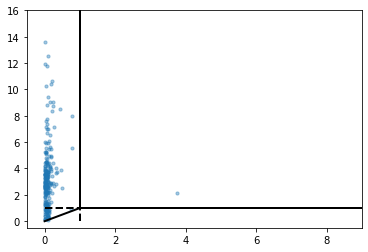

In [169]:
plt.scatter(ratio_a, ratio_B/10, s = 10, alpha = 0.4)
plt.ylim([-.5,16])
plt.xlim([-.5,9])
plt.plot([1, 1], [1, 18], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [160]:
Fmr1_elon_table[Fmr1_elon_table.ratio_a > 0.6]

,index,gene_name,transcript_ID,elon_rate,a,B,ratio_a,ratio_B
5,268,Act57B,FBtr0071519,"[1.9662305743261106, 1.96623057432611, 1.96623...",0.004578,0.343220,0.780204,55.395919
21,29,CG13992,FBtr0309288,"[0.4103868816429291, 0.3445016583948867, 0.472...",0.022011,1.563565,0.778675,80.121208
105,63,Lip4,FBtr0304119,"[1.5449510659752097, 1.4465985135939787, 1.210...",0.017178,0.534635,0.740969,9.248128
169,547,SpdS,FBtr0082078,"[1.4269386349695703, 1.8459972902976327, 1.845...",0.036793,0.358423,3.771191,21.239972
195,658,betaTub97EF,FBtr0334906,"[0.7894090504526006, 1.1328334406940848, 1.132...",0.009432,1.201301,35.159287,4478.073851


show reduced elongation rate by 50% and look at how that effects it. 